In [ ]:
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
# load data
imdb = tfds.load("imdb_reviews", as_supervised = True, with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmpcw0s9nd3tfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.565a5d9facb947cdb687b62161b1f2e5...
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL5VCI1/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# prepare empty lists

data, info = imdb
train, test = data['train'], data['test']

train_sentences, train_labels = [], []
test_sentences, test_labels = [], []

In [ ]:
# turn data into a list

for sentence, label in train:
  train_sentences.append(str(sentence.numpy()))
  train_labels.append(label.numpy())

for sentence, label in test:
  test_sentences.append(str(sentence.numpy()))
  test_labels.append(label.numpy())

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_sentences[:10]

In [ ]:
# settings and prepare tokenizer 
vocab_size = 10000
oov_token = "<OOV>"
max_length = 200
trunc_type = "post"
embedding_dim = 32

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(train_sentences)


In [ ]:
# tokenize the sentences

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences_padded = pad_sequences(train_sequences, maxlen = max_length, truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences_padded = pad_sequences(test_sequences, maxlen = max_length, truncating = trunc_type)

In [ ]:
# define the model (AVG POOL) 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
                    Embedding(input_dim = vocab_size, 
                              output_dim = embedding_dim, 
                              input_length = max_length),
                    GlobalAveragePooling1D(),
                    Dense(6, activation = "relu"), 
                    Dense(1, activation = "sigmoid")
])

model.summary()
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ['accuracy'])
model.fit(train_sequences_padded, train_labels, 
          epochs = 7, 
          validation_data = (test_sequences_padded, test_labels))

In [ ]:
# define another model (LSTM)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
model2 = Sequential([
                     Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                               input_length = max_length), 
                     Bidirectional(LSTM(16)), 
                     Dense(8, activation = "relu"),
                     Dense(1, activation = "sigmoid")
])

model2.summary()

model2.compile(optimizer = "Adam",   # Adam(learning_rate = 0.0001), 
               loss = "binary_crossentropy", 
               metrics = ['accuracy'])

model2.fit(train_sequences_padded, train_labels, 
           epochs = 5, 
           validation_data = (test_sequences_padded, test_labels))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 32)           320000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 8)                 264       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 326,545
Trainable params: 326,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
782/782 [==============================] - 20s 23ms/step - loss: 0.4829 - accuracy: 0.7612 - val_loss: 0

In [ ]:
# define another model (CONV + AVG POOL)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
model3 = Sequential([
                     Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                               input_length = max_length), 
                     Conv1D(32, 5, activation = "relu"),
                     GlobalAveragePooling1D(), 
                     Dense(8, activation = "relu"),
                     Dense(1, activation = "sigmoid")
])

model3.summary()

model3.compile(optimizer = 'Adam',        # Adam(learning_rate = 0.0001), 
               loss = "binary_crossentropy", 
               metrics = ['accuracy'])

model3.fit(train_sequences_padded, train_labels, 
           epochs = 10, 
           validation_data = (test_sequences_padded, test_labels))

In [111]:
# define another model (GRU)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GRU, Dense
from tensorflow.keras.optimizers import Adam
model4 = Sequential([
                     Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                               input_length = max_length), 
                     GRU(16), 
                     Dense(8, activation = "relu"),
                     Dense(1, activation = "sigmoid")
])

model4.summary()

model4.compile(optimizer = 'Adam',        # Adam(learning_rate = 0.0001), 
               loss = "binary_crossentropy", 
               metrics = ['accuracy'])

model4.fit(train_sequences_padded, train_labels, 
           epochs = 10, 
           validation_data = (test_sequences_padded, test_labels))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 32)           320000    
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense_26 (Dense)            (None, 8)                 136       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 322,545
Trainable params: 322,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 14s 16ms/step - loss: 0.5108 - accuracy: 0.7358 - val_loss: 0.3939 - val_accuracy: 0.8358
Epoch 2/10
782/782 [===============

KeyboardInterrupt: ignored

In [ ]:
# define another model (RNN) - VERY SLOW

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
model5 = Sequential([
                     Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                               input_length = max_length), 
                     SimpleRNN(16), 
                     Dense(8, activation = "relu"),
                     Dense(1, activation = "sigmoid")
])

model5.summary()

model5.compile(optimizer = 'Adam',        # Adam(learning_rate = 0.0001), 
               loss = "binary_crossentropy", 
               metrics = ['accuracy'])

model5.fit(train_sequences_padded, train_labels, 
           epochs = 10, 
           validation_data = (test_sequences_padded, test_labels))

In [85]:
# try out a callback 
from tensorflow.keras.optimizers import Adam

model = Sequential([
                    Embedding(input_dim = vocab_size, 
                              output_dim = embedding_dim, 
                              input_length = max_length),
                    GlobalAveragePooling1D(),
                    Dense(6, activation = "relu"), 
                    Dense(1, activation = "sigmoid")
])

model.summary()

from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') - logs.get('val_accuracy') > 0.04 :
      self.model.stop_training = True
      print("\n")
      print("Stopping Training")
      print("\n")

callback = myCallback()

model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = "binary_crossentropy", 
              metrics = ['accuracy'])

history = model.fit(train_sequences_padded, train_labels, 
                    epochs = 25, 
                    validation_data = (test_sequences_padded, test_labels), 
                    callbacks = [callback])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 32)           320000    
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 6)                 198       
                                                                 
 dense_23 (Dense)            (None, 1)                 7         
                                                                 
Total params: 320,205
Trainable params: 320,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
782/782 [==============================] - 5s 5ms/step - loss: 0.6889 - accuracy: 0.6010 - val_loss: 0

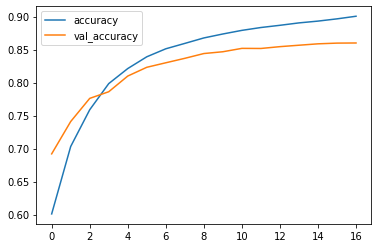

In [94]:
import matplotlib.pyplot as plt

def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history["val_" + metric])
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_history(history, "accuracy")

In [108]:
for s in test_sentences[:5]:
  print(s)
  print("\n")

print(test_labels[:5])

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."


b"A blackly comic tale of a down-trodden priest, Nazari

In [109]:
out = model3(test_sequences_padded[:5])
print(out)
print(np.round(out))

tf.Tensor(
[[0.32172787]
 [0.42671365]
 [0.02173967]
 [0.04383446]
 [0.826202  ]], shape=(5, 1), dtype=float32)
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]]
